In [1]:
from scipy import stats as sci
import numpy as np
import glob
import obspy
from Process import gen_scalograms
import os


eids = []
with open('./eveQB_removed.dat') as f:
    lines = f.readlines()
    for i in lines:
        qs = i.split('\n')[0]
        eids.append(qs)
# print(eids)
eids[531:680]

['texnet2018feve',
 'texnet2017ehhm',
 'texnet2018yrcv',
 'texnet2021efid',
 'texnet2021xroq',
 'texnet2021stlr',
 'texnet2019wiou',
 'texnet2020yckh',
 'texnet2017dunt',
 'texnet2018tnol',
 'texnet2018nzip',
 'texnet2021gusq',
 'texnet2019wrzt',
 'texnet2018qbuc',
 'texnet2020seyj',
 'texnet2022uyef',
 'texnet2024etyz',
 'texnet2018nbmz',
 'texnet2023sogp',
 'texnet2019azmg',
 'texnet2021uqol',
 'texnet2017jzgf',
 'texnet2020rjcc',
 'texnet2019gpgy',
 'texnet2017onxg',
 'texnet2018jryg',
 'texnet2019lchv',
 'texnet2020nffg',
 'texnet2022ycnv',
 'texnet2020qjjv',
 'texnet2020spxa',
 'texnet2017akpm',
 'texnet2018kcqo',
 'texnet2019eoqb',
 'texnet2019jiox',
 'texnet2019svfz',
 'texnet2019ytaj',
 'texnet2018hcbc',
 'texnet2021jxgf',
 'texnet2023unkp',
 'texnet2020lwhw',
 'texnet2021sruc',
 'texnet2019eopd',
 'texnet2018xwzz',
 'texnet2020fyyg',
 'texnet2019zhls',
 'texnet2019mwfx',
 'texnet2020gvbj',
 'texnet2020ihks',
 'texnet2020ujtv',
 'texnet2019lapg',
 'texnet2019uuic',
 'texnet2020

(3, 6000, 3)
P/S ratio: 0.11206687629585392


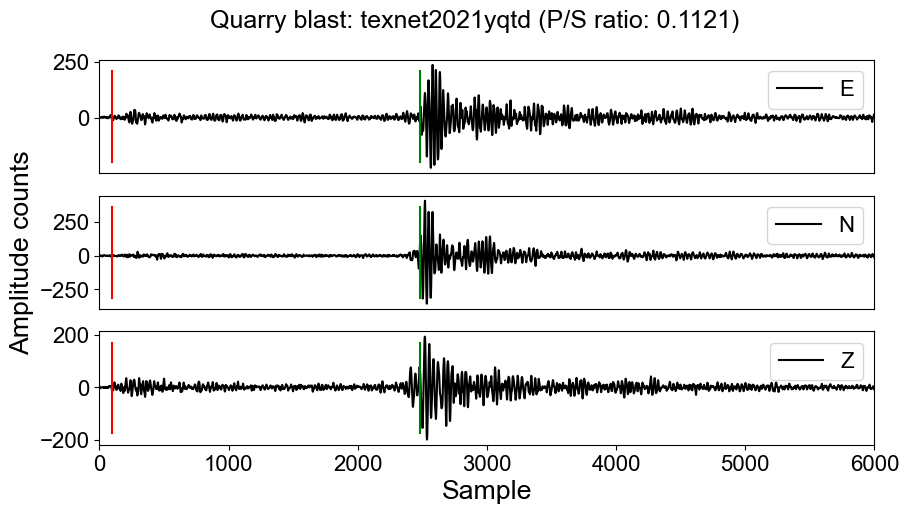

In [11]:
import obspy
import numpy as np
import matplotlib.pyplot as plt

datfinq = []

pa = (r'Data/quarryblast_events/texnet2021yqtd.qml')
pa1 = (r'Data/quarryblast_waveforms/texnet2021yqtd.mseed')
cat = obspy.read_events(pa)
st = obspy.read(pa1)
st = st.resample(100)
st = st.merge(fill_value=0)
st = st.filter(type='bandpass', freqmin = 1.0, freqmax = 45, corners=2, zerophase=True)
st = st.taper(max_percentage=0.001, type='cosine', max_length=2) 

for i in cat[0].picks:
    dat = []
    if i.phase_hint == 'P':
        st2 = st.copy()
        st2 = st2.select(station=i.waveform_id.station_code)
        if len(st2) == 3:
            if len(st2[2].data) >= 6000:
                t = obspy.UTCDateTime(i.time)
                stall = st2.trim(t - 1, t + 59 - 0.01)
                a0 = stall[0].data
                a1 = stall[1].data
                a2 = stall[2].data
                if (len(a0) == 6000) and (len(a1) == 6000) and (len(a2) == 6000):
                    dat.append(a0)
                    dat.append(a1)
                    dat.append(a2)

            if (len(a0) == 6000):
                dat = np.array(dat)    
                datfinq.append(dat.T)

print(np.shape(datfinq))
datfinq = np.array(datfinq)

datfinq = datfinq[2, :, :]

### Calculate the P/S amplitude
p_arrival_samplesq = [100, 100, 100] # First P arrival in three components
s_arrival_samplesq = [2480, 2480, 2480]  # First S arrival in three components


internal = 20
noise_window_size = 20
bp = p_arrival_samplesq[0] - 20 
ep = p_arrival_samplesq[0] + 20  
bs = s_arrival_samplesq[0] - 20  
es = s_arrival_samplesq[0] + 20  
bn = bp - 3*noise_window_size
en = bp  - noise_window_size

p_energies = []
s_energies = []

Pn = np.var(datfinq[bp:ep, 0]) + np.var(datfinq[bp:ep, 1]) + np.var(datfinq[bp:ep, 2])
Sn = np.var(datfinq[bs:es, 0]) + np.var(datfinq[bs:es, 1]) + np.var(datfinq[bs:es, 2]) 
Nn = np.var(datfinq[bn:en, 0]) + np.var(datfinq[bn:en, 1]) + np.var(datfinq[bn:en, 2])
    
p_ener = np.sqrt(Pn - Nn)
s_ener = np.sqrt(Sn - Nn)
    
ps_ratio = p_ener / s_ener
p_energies.append(p_ener)
s_energies.append(s_ener)
    
print(f"P/S ratio: {ps_ratio}")

# Plot figure
fig = plt.figure(figsize=(10, 5)) 
ax = [plt.subplot(3, 1, i + 1) for i in range(3)]

font = {'family': 'Arial', 'weight': 'normal', 'size': 16}
plt.rc('font', **font)

kk = ['E', 'N', 'Z']
for c, a in enumerate(ax):
    im = datfinq[:, c]
    a.plot(np.arange(len(im)), im, 'k', label=kk[c])
    
    a.axvline(p_arrival_samplesq[c], color='red', linestyle='-', label='', ymin=0.1, ymax=0.9)
    a.axvline(s_arrival_samplesq[c], color='green', linestyle='-', label='', ymin=0.1, ymax=0.9)
    
    a.legend(loc='upper right')
    a.set_xlim([0, len(im)])
    
    if c <= 1:
        a.set_xticklabels([])
        a.set_xticks([])
    if c == 1:
        a.set_ylabel('Amplitude counts', fontsize='large', fontweight='normal')
    
a.set_xlabel('Sample', fontsize='large')
fig.suptitle(f"Quarry blast: texnet2021yqtd (P/S ratio: {ps_ratio:.4f})", fontsize=18, fontweight='normal')

plt.subplots_adjust(wspace=0, hspace=0.2) 


# fig.savefig('Fig/Fig2/EQ_w.jpg', bbox_inches='tight', transparent=True, dpi=300)

plt.show()


(6, 6000, 3)
P/S ratio: 0.04177775008048654


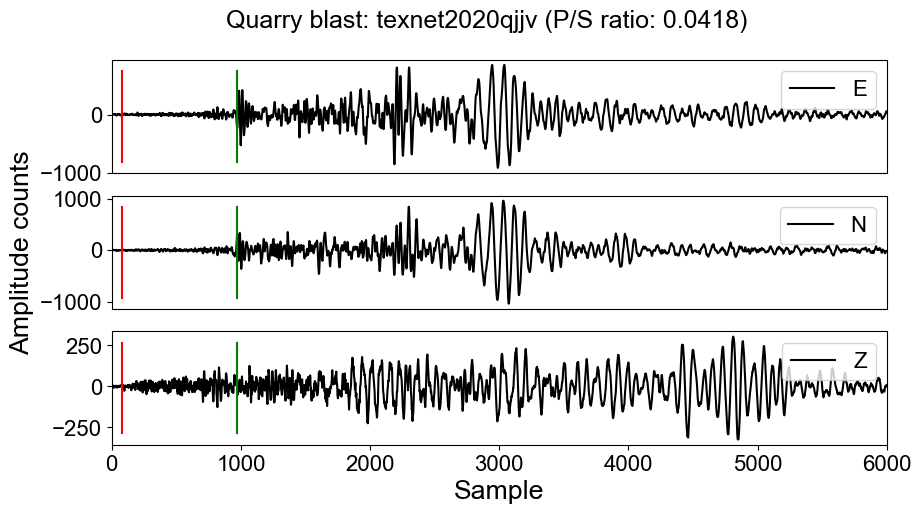

In [25]:
import obspy
import numpy as np
import matplotlib.pyplot as plt

datfinq = []

pa = (r'Data/quarryblast_events/texnet2020qjjv.qml')
pa1 = (r'Data/quarryblast_waveforms/texnet2020qjjv.mseed')
cat = obspy.read_events(pa)
st = obspy.read(pa1)
st = st.resample(100)
st = st.merge(fill_value=0)
st = st.filter(type='bandpass', freqmin = 1.0, freqmax = 45, corners=2, zerophase=True)
st = st.taper(max_percentage=0.001, type='cosine', max_length=2) 

for i in cat[0].picks:
    dat = []
    if i.phase_hint == 'P':
        st2 = st.copy()
        st2 = st2.select(station=i.waveform_id.station_code)
        if len(st2) == 3:
            if len(st2[2].data) >= 6000:
                t = obspy.UTCDateTime(i.time)
                stall = st2.trim(t - 1, t + 59 - 0.01)
                a0 = stall[0].data
                a1 = stall[1].data
                a2 = stall[2].data
                if (len(a0) == 6000) and (len(a1) == 6000) and (len(a2) == 6000):
                    dat.append(a0)
                    dat.append(a1)
                    dat.append(a2)

            if (len(a0) == 6000):
                dat = np.array(dat)    
                datfinq.append(dat.T)

print(np.shape(datfinq))
datfinq = np.array(datfinq)

datfinq = datfinq[0, :, :]

### Calculate the P/S amplitude
p_arrival_samplesq = [80, 80, 80] # First P arrival in three components
s_arrival_samplesq = [970, 970, 970]  # First S arrival in three components


internal = 20
noise_window_size = 20
bp = p_arrival_samplesq[0] - 20 
ep = p_arrival_samplesq[0] + 20  
bs = s_arrival_samplesq[0] - 20  
es = s_arrival_samplesq[0] + 20  
bn = bp - 3*noise_window_size
en = bp  - noise_window_size

p_energies = []
s_energies = []

Pn = np.var(datfinq[bp:ep, 0]) + np.var(datfinq[bp:ep, 1]) + np.var(datfinq[bp:ep, 2])
Sn = np.var(datfinq[bs:es, 0]) + np.var(datfinq[bs:es, 1]) + np.var(datfinq[bs:es, 2]) 
Nn = np.var(datfinq[bn:en, 0]) + np.var(datfinq[bn:en, 1]) + np.var(datfinq[bn:en, 2])
    
p_ener = np.sqrt(Pn - Nn)
s_ener = np.sqrt(Sn - Nn)
    
ps_ratio = p_ener / s_ener
p_energies.append(p_ener)
s_energies.append(s_ener)
    
print(f"P/S ratio: {ps_ratio}")

# Plot figure
fig = plt.figure(figsize=(10, 5)) 
ax = [plt.subplot(3, 1, i + 1) for i in range(3)]

font = {'family': 'Arial', 'weight': 'normal', 'size': 16}
plt.rc('font', **font)

kk = ['E', 'N', 'Z']
for c, a in enumerate(ax):
    im = datfinq[:, c]
    a.plot(np.arange(len(im)), im, 'k', label=kk[c])
    
    a.axvline(p_arrival_samplesq[c], color='red', linestyle='-', label='', ymin=0.1, ymax=0.9)
    a.axvline(s_arrival_samplesq[c], color='green', linestyle='-', label='', ymin=0.1, ymax=0.9)
    
    a.legend(loc='upper right')
    a.set_xlim([0, len(im)])
    
    if c <= 1:
        a.set_xticklabels([])
        a.set_xticks([])
    if c == 1:
        a.set_ylabel('Amplitude counts', fontsize='large', fontweight='normal')
    
a.set_xlabel('Sample', fontsize='large')
fig.suptitle(f"Quarry blast: texnet2020qjjv (P/S ratio: {ps_ratio:.4f})", fontsize=18, fontweight='normal')

plt.subplots_adjust(wspace=0, hspace=0.2) 


# fig.savefig('Fig/Fig2/EQ_w.jpg', bbox_inches='tight', transparent=True, dpi=300)

plt.show()


(3, 6000, 3)
P/S ratio: 0.008630784936512781


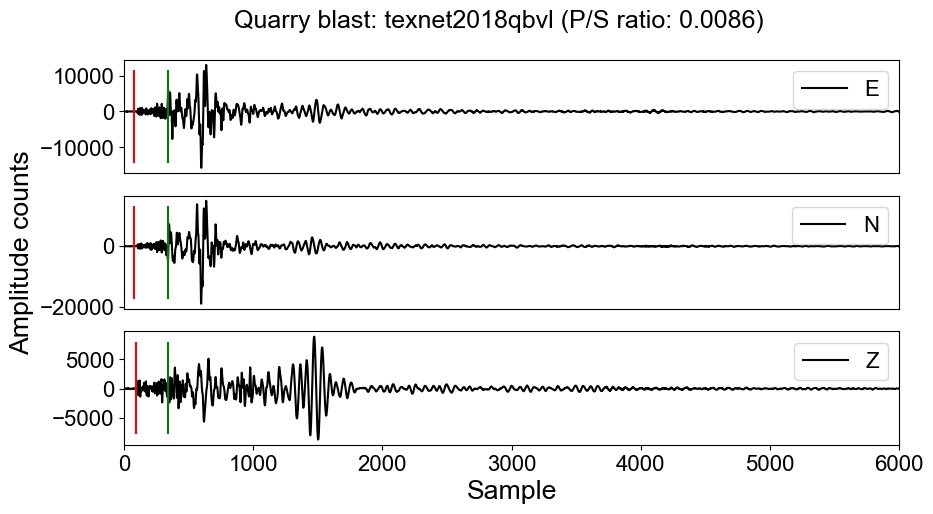

In [33]:
import obspy
import numpy as np
import matplotlib.pyplot as plt

datfinq = []

pa = (r'Data/quarryblast_events/texnet2018qbvl.qml')
pa1 = (r'Data/quarryblast_waveforms/texnet2018qbvl.mseed')
cat = obspy.read_events(pa)
st = obspy.read(pa1)
st = st.resample(100)
st = st.merge(fill_value=0)
st = st.filter(type='bandpass', freqmin = 1.0, freqmax = 45, corners=2, zerophase=True)
st = st.taper(max_percentage=0.001, type='cosine', max_length=2) 

for i in cat[0].picks:
    dat = []
    if i.phase_hint == 'P':
        st2 = st.copy()
        st2 = st2.select(station=i.waveform_id.station_code)
        if len(st2) == 3:
            if len(st2[2].data) >= 6000:
                t = obspy.UTCDateTime(i.time)
                stall = st2.trim(t - 1, t + 59 - 0.01)
                a0 = stall[0].data
                a1 = stall[1].data
                a2 = stall[2].data
                if (len(a0) == 6000) and (len(a1) == 6000) and (len(a2) == 6000):
                    dat.append(a0)
                    dat.append(a1)
                    dat.append(a2)

            if (len(a0) == 6000):
                dat = np.array(dat)    
                datfinq.append(dat.T)

print(np.shape(datfinq))
datfinq = np.array(datfinq)

datfinq = datfinq[0, :, :]

### Calculate the P/S amplitude
p_arrival_samplesq = [80, 80, 90] # First P arrival in three components
s_arrival_samplesq = [340, 340, 340]  # First S arrival in three components


internal = 20
noise_window_size = 20
bp = p_arrival_samplesq[0] - 20 
ep = p_arrival_samplesq[0] + 20  
bs = s_arrival_samplesq[0] - 20  
es = s_arrival_samplesq[0] + 20  
bn = bp - 3*noise_window_size
en = bp  - noise_window_size

p_energies = []
s_energies = []

Pn = np.var(datfinq[bp:ep, 0]) + np.var(datfinq[bp:ep, 1]) + np.var(datfinq[bp:ep, 2])
Sn = np.var(datfinq[bs:es, 0]) + np.var(datfinq[bs:es, 1]) + np.var(datfinq[bs:es, 2]) 
Nn = np.var(datfinq[bn:en, 0]) + np.var(datfinq[bn:en, 1]) + np.var(datfinq[bn:en, 2])
    
p_ener = np.sqrt(Pn - Nn)
s_ener = np.sqrt(Sn - Nn)
    
ps_ratio = p_ener / s_ener
p_energies.append(p_ener)
s_energies.append(s_ener)
    
print(f"P/S ratio: {ps_ratio}")

# Plot figure
fig = plt.figure(figsize=(10, 5)) 
ax = [plt.subplot(3, 1, i + 1) for i in range(3)]

font = {'family': 'Arial', 'weight': 'normal', 'size': 16}
plt.rc('font', **font)

kk = ['E', 'N', 'Z']
for c, a in enumerate(ax):
    im = datfinq[:, c]
    a.plot(np.arange(len(im)), im, 'k', label=kk[c])
    
    a.axvline(p_arrival_samplesq[c], color='red', linestyle='-', label='', ymin=0.1, ymax=0.9)
    a.axvline(s_arrival_samplesq[c], color='green', linestyle='-', label='', ymin=0.1, ymax=0.9)
    
    a.legend(loc='upper right')
    a.set_xlim([0, len(im)])
    
    if c <= 1:
        a.set_xticklabels([])
        a.set_xticks([])
    if c == 1:
        a.set_ylabel('Amplitude counts', fontsize='large', fontweight='normal')
    
a.set_xlabel('Sample', fontsize='large')
fig.suptitle(f"Quarry blast: texnet2018qbvl (P/S ratio: {ps_ratio:.4f})", fontsize=18, fontweight='normal')

plt.subplots_adjust(wspace=0, hspace=0.2) 


# fig.savefig('Fig/Fig2/EQ_w.jpg', bbox_inches='tight', transparent=True, dpi=300)

plt.show()


(4, 6000, 3)
P/S ratio: 0.27534623009309367


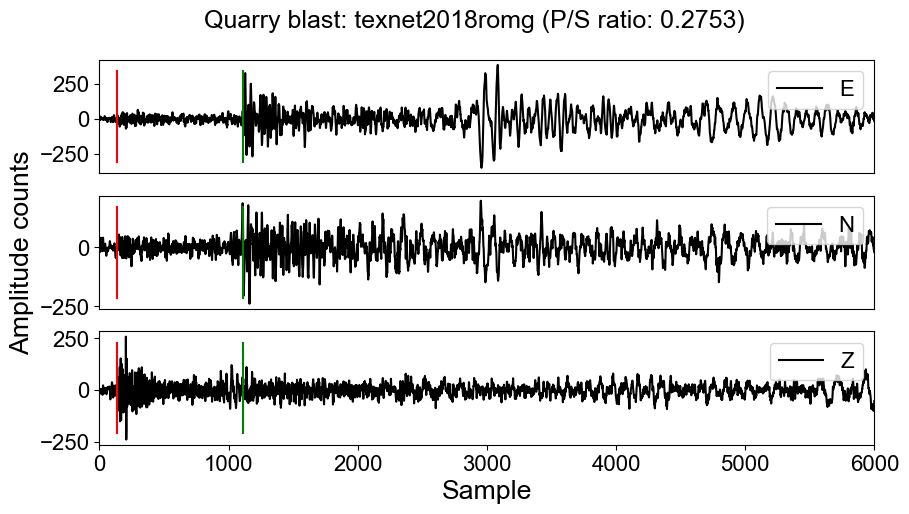

In [55]:
import obspy
import numpy as np
import matplotlib.pyplot as plt

datfinq = []

pa = (r'Data/quarryblast_events/texnet2018romg.qml')
pa1 = (r'Data/quarryblast_waveforms/texnet2018romg.mseed')
cat = obspy.read_events(pa)
st = obspy.read(pa1)
st = st.resample(100)
st = st.merge(fill_value=0)
st = st.filter(type='bandpass', freqmin = 1.0, freqmax = 45, corners=2, zerophase=True)
st = st.taper(max_percentage=0.001, type='cosine', max_length=2) 

for i in cat[0].picks:
    dat = []
    if i.phase_hint == 'P':
        st2 = st.copy()
        st2 = st2.select(station=i.waveform_id.station_code)
        if len(st2) == 3:
            if len(st2[2].data) >= 6000:
                t = obspy.UTCDateTime(i.time)
                stall = st2.trim(t - 1, t + 59 - 0.01)
                a0 = stall[0].data
                a1 = stall[1].data
                a2 = stall[2].data
                if (len(a0) == 6000) and (len(a1) == 6000) and (len(a2) == 6000):
                    dat.append(a0)
                    dat.append(a1)
                    dat.append(a2)

            if (len(a0) == 6000):
                dat = np.array(dat)    
                datfinq.append(dat.T)

print(np.shape(datfinq))
datfinq = np.array(datfinq)

datfinq = datfinq[3, :, :]

### Calculate the P/S amplitude
p_arrival_samplesq = [140, 140, 140] # First P arrival in three components
s_arrival_samplesq = [1115, 1115, 1115]  # First S arrival in three components


internal = 20
noise_window_size = 20
bp = p_arrival_samplesq[0] - 20 
ep = p_arrival_samplesq[0] + 20  
bs = s_arrival_samplesq[0] - 20  
es = s_arrival_samplesq[0] + 20  
bn = bp - 3*noise_window_size
en = bp  - noise_window_size

p_energies = []
s_energies = []

Pn = np.var(datfinq[bp:ep, 0]) + np.var(datfinq[bp:ep, 1]) + np.var(datfinq[bp:ep, 2])
Sn = np.var(datfinq[bs:es, 0]) + np.var(datfinq[bs:es, 1]) + np.var(datfinq[bs:es, 2]) 
Nn = np.var(datfinq[bn:en, 0]) + np.var(datfinq[bn:en, 1]) + np.var(datfinq[bn:en, 2])
    
p_ener = np.sqrt(Pn - Nn)
s_ener = np.sqrt(Sn - Nn)
    
ps_ratio = p_ener / s_ener
p_energies.append(p_ener)
s_energies.append(s_ener)
    
print(f"P/S ratio: {ps_ratio}")

# Plot figure
fig = plt.figure(figsize=(10, 5)) 
ax = [plt.subplot(3, 1, i + 1) for i in range(3)]

font = {'family': 'Arial', 'weight': 'normal', 'size': 16}
plt.rc('font', **font)

kk = ['E', 'N', 'Z']
for c, a in enumerate(ax):
    im = datfinq[:, c]
    a.plot(np.arange(len(im)), im, 'k', label=kk[c])
    
    a.axvline(p_arrival_samplesq[c], color='red', linestyle='-', label='', ymin=0.1, ymax=0.9)
    a.axvline(s_arrival_samplesq[c], color='green', linestyle='-', label='', ymin=0.1, ymax=0.9)
    
    a.legend(loc='upper right')
    a.set_xlim([0, len(im)])
    
    if c <= 1:
        a.set_xticklabels([])
        a.set_xticks([])
    if c == 1:
        a.set_ylabel('Amplitude counts', fontsize='large', fontweight='normal')
    
a.set_xlabel('Sample', fontsize='large')
fig.suptitle(f"Quarry blast: texnet2018romg (P/S ratio: {ps_ratio:.4f})", fontsize=18, fontweight='normal')

plt.subplots_adjust(wspace=0, hspace=0.2) 


# fig.savefig('Fig/Fig2/EQ_w.jpg', bbox_inches='tight', transparent=True, dpi=300)

plt.show()
